In [1]:
%load_ext Cython
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt  
import scipy.interpolate
from scipy.ndimage.interpolation import rotate

In [32]:
def low_pass_filter(img):
    n0, n1 = img.shape

    x, y = np.mgrid[0:n0, 0:n1]
    x -= n0//2
    y -= n1//2
    r = np.sqrt(x*x + y*y)

    fil = np.fft.ifftshift(np.where(r < min(n0, n1)/3, 1, 0))

    filtered_img = np.fft.ifft2( np.fft.fft2(img) * fil ).real
    return filtered_img

def slices_gen(img, thetas):
    l_max = np.max(img.shape)
    slices = np.zeros([len(thetas), l_max], dtype = np.float64)
    for i, theta in enumerate(thetas):
        rotated_img = rotate(img, -theta, reshape = False, prefilter = False)
        mid = rotated_img[rotated_img.shape[0]//2, :]
        pad_width = [int(np.floor(l_max - len(mid))/2.), int(np.ceil((l_max - len(mid))/2.))]
        mid = np.pad(mid, pad_width, mode = "constant", constant_values = 0)
        slices[i] = mid
    return slices

def radon(img, thetas):
    l_max = np.max(img.shape)
    sinogram = np.zeros([len(thetas), l_max], dtype = np.float64)
    for i, theta in enumerate(thetas):
        rotated_img = rotate(img, -theta, reshape = False, prefilter = False)
        proj = np.sum(rotated_img, axis = 0)
        pad_width = [int(np.floor(l_max - len(proj))/2.), int(np.ceil((l_max - len(proj))/2.))]
        proj = np.pad(proj, pad_width, mode = "constant", constant_values = 0)
        sinogram[i] = proj
    return sinogram.T

def iradon(sinogram, thetas):
    n0, n1 = sinogram.shape
    assert(n1 == len(thetas))
    thetas = thetas / 180 * np.pi
    fil = np.abs(np.fft.fftfreq(n0)).reshape((-1, 1))
    filtered_sino = np.fft.ifft(np.fft.fft(sinogram, axis = 0) * fil, axis = 0).real

    x, y = np.mgrid[0:n0,0:n0]
    x -= n0//2
    y -= n0//2
    t = np.arange(n0) - n0//2

    recon = np.zeros([n0,n0], dtype = np.float64)
    for i,theta in enumerate(thetas):
        tt = -x*np.sin(theta) + y*np.cos(theta)
        back_proj = np.interp(tt, t, filtered_sino[:, i])
        recon += back_proj
    return recon

def recon_ftm(sinogram, thetas):
    thetas = thetas/180. * np.pi
    N, M = sinogram.shape
    ft_sinogram = np.fft.fftshift(np.fft.fft(sinogram, axis=0), axes=0)
    model = np.zeros((N,N), dtype = np.complex128)
    dth = thetas[1] - thetas[0]
    df = 1./N
    
    freq = np.fft.fftshift(np.fft.fftfreq(N))
    th, f = np.meshgrid(thetas, freq)
    fx = f*np.cos(th)
    fy = f*np.sin(th)
    
    ffx, ffy = np.meshgrid(freq, freq)
    
    for i in range(N):
        for j in range(N):
            u = ffx[i,j]
            v = ffy[i,j]
            kernel = np.sinc((u-fx)/df)*np.sinc((v-fy)/df)*np.abs(f)
            model[i,j] = df*dth*np.sum(kernel * ft_sinogram)
    return model
        

In [33]:
phantom = np.load("phantom_small.npy")
phantom = low_pass_filter(phantom)

In [34]:
thetas = np.arange(0,180,1, dtype=np.float64)
sinogram = radon(phantom, thetas)
recon1 = iradon(sinogram, thetas)

In [35]:
model = recon_ftm(sinogram, thetas)

0.0174532925199


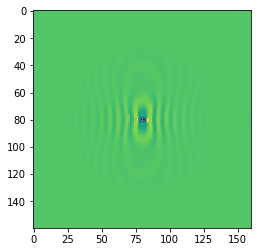

In [36]:
plt.imshow(model.real)

In [37]:
re = np.fft.ifft2(np.fft.ifftshift(model)).real

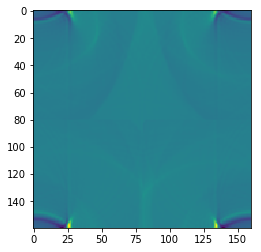

In [38]:
plt.imshow(re)